In [1]:
import numpy as np

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import random
import sys
import glob
sys.path.append("./")

2023-06-28 13:04:52.205367: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-28 13:04:52.268118: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

#### Configuration file

In [4]:
from signet.configs.Conv1D_LSTM_CTC_Loss import Conv1D_LSTM_CTC_Loss
CFG = Conv1D_LSTM_CTC_Loss()

#### Set random seeds and training strategy

#### Prepare dataset for training 

In [5]:
from signet.dataset.utils import get_tfrec_dataset

In [6]:
ALL_FILENAMES = glob.glob('../dataset/tdf_data/*.tfrecords')
print(len(ALL_FILENAMES))

120165


In [7]:
ROOT_DIR = "../dataset"
supp_df = pd.read_csv("../dataset/supplemental_metadata.csv")
train_df = pd.read_csv("../dataset/train.csv")

In [8]:
import numpy as np
from sklearn.model_selection import GroupKFold

In [9]:
ds = get_tfrec_dataset(ALL_FILENAMES,CFG,True)
for x in ds:
    temp_train = x
    break
inp,y_true = temp_train

2023-06-28 13:05:01.025351: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 646 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:41:00.0, compute capability: 7.5
2023-06-28 13:05:02.043345: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [120165]
	 [[{{node Placeholder/_0}}]]
2023-06-28 13:05:02.043770: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [120165]
	 [[{{node Placeholder/_0}}]]


#### Prepare model

In [11]:
from signet.trainer.ctc_loss_trainer import train_conv1d_mhsa_ctc_model
from signet.models.feature_extractor import Cnn1dMhsaFeatureExtractor

In [12]:
model = Cnn1dMhsaFeatureExtractor(CFG)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 708)]   0           []                               
                                                                                                  
 masking (Masking)              (None, 384, 708)     0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Dense)              (None, 384, 192)     135936      ['masking[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 384, 192)     768         ['stem_conv[0][0]']              
                                                                                              

In [20]:
train_files= ALL_FILENAMES[:10000]
valid_files= ALL_FILENAMES[1000:5000]
experiment_name="simple_exp"

Using single GPU
REPLICAS: 1

Model: "awp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 708)]   0           []                               
                                                                                                  
 masking (Masking)              (None, 384, 708)     0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Dense)              (None, 384, 192)     135936      ['masking[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 384, 192)     768         ['stem_conv[0][0]']              
                                                                  

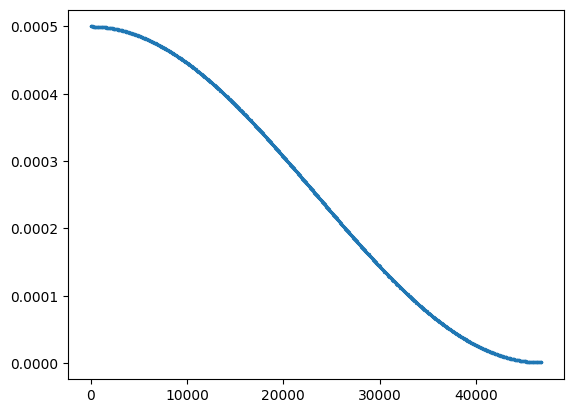

ValueError: Could not infer the size of the data. With `steps_per_execution > 1`, you must specify the number of steps to run.

In [21]:
import tensorflow as tf
import json
import gc 
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.mixed_precision as mixed_precision
sys.path.append("./signet/trainer")
from tf_utils.schedules import OneCycleLR, ListedLR
from tf_utils.callbacks import Snapshot, SWA
from tf_utils.learners import FGM, AWP

from signet.dataset.utils import get_tfrec_dataset
from signet.models.feature_extractor import Cnn1dMhsaFeatureExtractor
from signet.losses.ctc import CTCLoss
from signet.configs.Conv1D_LSTM_CTC_Loss import Conv1D_LSTM_CTC_Loss
from signet.trainer.utils import ctc_decode
from signet.trainer.callbacks import LevenshteinCallback

from signet.losses.metrics import normalized_levenshtein_distance,word_accuracy
import os

def get_strategy(CFG: Conv1D_LSTM_CTC_Loss):
    if CFG.device == "GPU"  or CFG.device=="CPU":
        ngpu = len(tf.config.experimental.list_physical_devices('GPU'))
        if ngpu>1:
            print("Using multi GPU")
            strategy = tf.distribute.MirroredStrategy()
        elif ngpu==1:
            print("Using single GPU")
            strategy = tf.distribute.get_strategy()
        else:
            print("Using CPU")
            strategy = tf.distribute.get_strategy()
            CFG.device = "CPU"

    AUTO     = tf.data.experimental.AUTOTUNE
    REPLICAS = strategy.num_replicas_in_sync
    print(f'REPLICAS: {REPLICAS}')
    
    return strategy, REPLICAS

os.makedirs(os.path.join(CFG.output_dir,experiment_name),exist_ok=True)
strategy, N_REPLICAS = get_strategy(CFG)    
tf.keras.backend.clear_session()
gc.collect()
tf.config.optimizer.set_jit(CFG.is_jit)

train_ds = get_tfrec_dataset(train_files, CFG,shuffle=32768)
valid_ds = get_tfrec_dataset(valid_files, CFG, shuffle=False)

num_train = len(train_files)
num_valid = len(valid_files)
steps_per_epoch = num_train//CFG.batch_size
with strategy.scope():
    dropout_step = CFG.dropout_start_epoch * steps_per_epoch
    model = Cnn1dMhsaFeatureExtractor(CFG)

    schedule = OneCycleLR(CFG.lr, CFG.epoch, warmup_epochs=CFG.epoch*CFG.warmup, steps_per_epoch=steps_per_epoch, resume_epoch=CFG.resume, decay_epochs=CFG.epoch, lr_min=CFG.lr_min, decay_type=CFG.decay_type, warmup_type='linear')
    decay_schedule = OneCycleLR(CFG.lr*CFG.weight_decay, CFG.epoch, warmup_epochs=CFG.epoch*CFG.warmup, steps_per_epoch=steps_per_epoch, resume_epoch=CFG.resume, decay_epochs=CFG.epoch, lr_min=CFG.lr_min*CFG.weight_decay, decay_type=CFG.decay_type, warmup_type='linear')
            
    awp_step = CFG.awp_start_epoch * steps_per_epoch
    if CFG.fgm:
        model = FGM(model.input, model.output, delta=CFG.awp_lambda, eps=0., start_step=awp_step)
    elif CFG.awp:
        model = AWP(model.input, model.output, delta=CFG.awp_lambda, eps=0., start_step=awp_step)

    opt = tfa.optimizers.RectifiedAdam(learning_rate=schedule, weight_decay=decay_schedule, sma_threshold=4)#, clipvalue=1.)
    opt = tfa.optimizers.Lookahead(opt,sync_period=5)

    model.compile(
        optimizer=opt,
        loss=[CTCLoss(CFG.blank_index)],
        metrics=[],
        steps_per_execution=steps_per_epoch,
        
    )

    if CFG.summary:
        print()
        model.summary()
        print()
        print(train_ds, valid_ds)
        print()
        schedule.plot()
        print()
    predictions = model.predict(valid_ds)

Using single GPU
REPLICAS: 1

Model: "awp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 708)]   0           []                               
                                                                                                  
 masking (Masking)              (None, 384, 708)     0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Dense)              (None, 384, 192)     135936      ['masking[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 384, 192)     768         ['stem_conv[0][0]']              
                                                                  

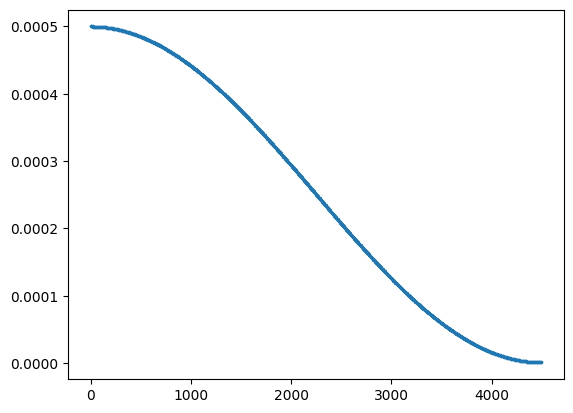


---------Starting experiment: simple_exp---------
train:1000 valid:1000



2023-06-27 06:44:41.406259: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-06-27 06:44:41.406695: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]


Epoch 1/300


2023-06-27 06:44:42.458091: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]
2023-06-27 06:44:42.458536: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]


Instructions for updating:
Prefer tf.tensor_scatter_nd_add, which offers the same functionality with well-defined read-write semantics.
Instructions for updating:
Prefer tf.tensor_scatter_nd_update, which offers the same functionality with well-defined read-write semantics.


In [11]:
train_conv1d_mhsa_ctc_model(experiment_name,CFG,train_files, valid_files)a